# 🏥 Medical VQA: CNN-LSTM Baseline Model
## WOA7015 Advanced Machine Learning - Alternative Assignment

**Part 1 of 4:** CNN-LSTM Baseline Implementation

This notebook implements a traditional CNN-LSTM architecture for Medical Visual Question Answering on the VQA-RAD dataset.

### Key Features:
- **Easy Data Loading:** Direct download from Hugging Face (no manual setup required)
- **Proper Data Splits:** Image-level GroupShuffleSplit to prevent data leakage
- **Attention Mechanism:** Improved fusion with visual attention
- **Class Imbalance Handling:** Weighted loss and evaluation stratification
- **Comprehensive Metrics:** Overall, closed-ended, and open-ended performance

---

## 📦 Part 1: Setup & Installation

In [ ]:
# Install required packages
!pip install -q torch torchvision
!pip install -q transformers datasets pillow
!pip install -q pandas numpy matplotlib seaborn scikit-learn tqdm
!pip install -q nltk

# Download NLTK data for BLEU score
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ All packages installed!")

✅ All packages installed!


In [ ]:
# Core imports
import os
import json
import random
import warnings
from pathlib import Path
from collections import Counter
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# Hugging Face
from datasets import load_dataset

# Sklearn
from sklearn.model_selection import GroupShuffleSplit

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🖥️ Using device: cuda
   GPU: Tesla T4
   Memory: 15.8 GB


## 📂 Part 2: Load VQA-RAD Dataset from Hugging Face

**No manual download required!** The dataset loads directly from Hugging Face Hub.

In [ ]:
print("📥 Loading VQA-RAD dataset from Hugging Face...")
print("   This may take a few minutes on first run (downloads ~100MB)\n")

# Load the VQA-RAD dataset from Hugging Face
# Dataset: https://huggingface.co/datasets/flaviagiammarino/vqa-rad
dataset = load_dataset("flaviagiammarino/vqa-rad")

print(f"✅ Dataset loaded successfully!")
print(f"\n📊 Dataset Structure:")
print(f"   Train split: {len(dataset['train'])} samples")
print(f"   Test split: {len(dataset['test'])} samples")
print(f"\n📋 Features: {dataset['train'].features}")

📥 Loading VQA-RAD dataset from Hugging Face...
   This may take a few minutes on first run (downloads ~100MB)



'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 5d4dcf61-5930-4ea3-b374-ab9458c36b53)')' thrown while requesting HEAD https://huggingface.co/datasets/flaviagiammarino/vqa-rad/resolve/bcf91e7654fb9d51c8ab6a5b82cacf3fafd2fae9/.huggingface.yaml
Retrying in 1s [Retry 1/5].


✅ Dataset loaded successfully!

📊 Dataset Structure:
   Train split: 1793 samples
   Test split: 451 samples

📋 Features: {'image': Image(mode=None, decode=True), 'question': Value('string'), 'answer': Value('string')}


🔍 Sample from training set:

  image: PIL Image (566, 555)
  question: are regions of the brain infarcted?
  answer: yes


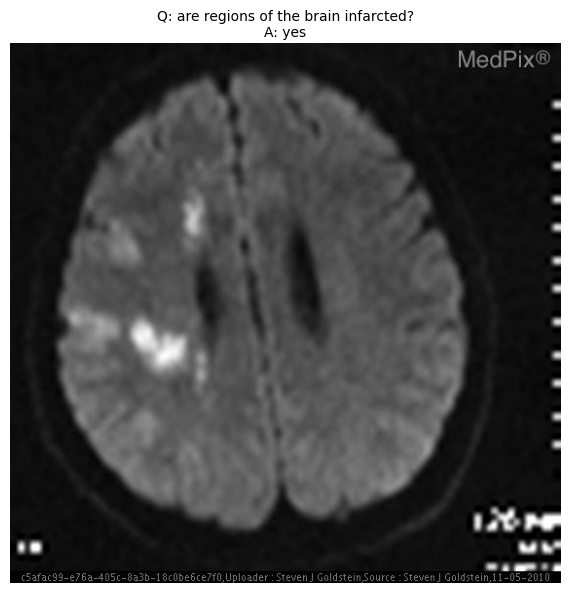

In [ ]:
# Explore the dataset structure
print("🔍 Sample from training set:\n")
sample = dataset['train'][0]
for key, value in sample.items():
    if key == 'image':
        print(f"  {key}: PIL Image {value.size}")
    else:
        print(f"  {key}: {value}")

# Display sample image
plt.figure(figsize=(6, 6))
plt.imshow(sample['image'])
plt.title(f"Q: {sample['question']}\nA: {sample['answer']}", fontsize=10, wrap=True)
plt.axis('off')
plt.tight_layout()
plt.show()

## 📊 Part 3: Data Exploration & Preprocessing

In [ ]:
def prepare_vqa_data(dataset) -> pd.DataFrame:
    """Convert Hugging Face dataset to DataFrame for analysis."""

    # Define closed-ended answers (yes/no, common modalities, planes)
    CLOSED_ANSWERS = {
        'yes', 'no',
        # Modalities
        'ct', 'mri', 'x-ray', 'xray', 'ct scan', 'mri scan', 'ultrasound',
        'ct - Loss', 'mr - flair', 'mr - t1w', 'mr - t2w',
        # Planes
        'axial', 'coronal', 'sagittal', 'transverse', 'frontal', 'lateral',
        # Counts
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
        'one', 'two', 'three', 'four', 'five', 'none',
    }

    def infer_answer_type(answer, question):
        """Infer if question is closed or open-ended."""
        answer_lower = str(answer).lower().strip()
        question_lower = str(question).lower()

        # Check if answer is in closed set
        if answer_lower in CLOSED_ANSWERS:
            return 'CLOSED'

        # Check question patterns for closed-ended
        closed_patterns = [
            'is there', 'is this', 'is it', 'are there', 'are these',
            'does this', 'does the', 'do you see', 'can you see',
            'how many', 'what type of imaging', 'what imaging',
            'what plane', 'which plane', 'what view'
        ]

        for pattern in closed_patterns:
            if pattern in question_lower:
                return 'CLOSED'

        return 'OPEN'

    records = []

    for split_name in ['train', 'test']:
        for idx, sample in enumerate(dataset[split_name]):
            answer = str(sample['answer']).lower().strip()
            question = str(sample['question'])

            # Infer answer type
            answer_type = infer_answer_type(answer, question)

            records.append({
                'split': split_name,
                'idx': idx,
                'image_id': f"{split_name}_{idx}",
                'question': question,
                'answer': answer,
                'answer_type': answer_type,
                'question_type': sample.get('question_type', 'other'),
            })

    return pd.DataFrame(records)

# Re-create analysis DataFrame
df = prepare_vqa_data(dataset)

print(f"📊 Dataset Overview:")
print(f"   Total QA pairs: {len(df)}")
print(f"   Train pairs: {len(df[df['split'] == 'train'])}")
print(f"   Test pairs: {len(df[df['split'] == 'test'])}")
print(f"   Unique answers: {df['answer'].nunique()}")

# Answer type distribution
print(f"\n📋 Answer Type Distribution:")
print(df['answer_type'].value_counts())
print(f"\n   CLOSED: {len(df[df['answer_type'] == 'CLOSED'])} ({len(df[df['answer_type'] == 'CLOSED'])/len(df)*100:.1f}%)")
print(f"   OPEN: {len(df[df['answer_type'] == 'OPEN'])} ({len(df[df['answer_type'] == 'OPEN'])/len(df)*100:.1f}%)")

📊 Dataset Overview:
   Total QA pairs: 2244
   Train pairs: 1793
   Test pairs: 451
   Unique answers: 517

📋 Answer Type Distribution:
answer_type
CLOSED    1422
OPEN       822
Name: count, dtype: int64

   CLOSED: 1422 (63.4%)
   OPEN: 822 (36.6%)


In [ ]:
# Analyze answer distribution
answer_counts = df['answer'].value_counts()

print(f"📊 Answer Distribution Analysis:")
print(f"   Total unique answers: {len(answer_counts)}")
print(f"   Answers appearing only once: {sum(answer_counts == 1)}")
print(f"   Answers appearing ≤5 times: {sum(answer_counts <= 5)}")

print(f"\n🔝 Top 20 Most Common Answers:")
top_20 = answer_counts.head(20)
for ans, count in top_20.items():
    pct = count / len(df) * 100
    print(f"   '{ans}': {count} ({pct:.1f}%)")

# Yes/No dominance
yes_no_count = answer_counts.get('yes', 0) + answer_counts.get('no', 0)
print(f"\n⚠️ Yes/No answers: {yes_no_count} ({yes_no_count/len(df)*100:.1f}% of total)")

📊 Answer Distribution Analysis:
   Total unique answers: 517
   Answers appearing only once: 263
   Answers appearing ≤5 times: 492

🔝 Top 20 Most Common Answers:
   'no': 606 (27.0%)
   'yes': 585 (26.1%)
   'axial': 43 (1.9%)
   'right': 26 (1.2%)
   'left': 19 (0.8%)
   'pa': 15 (0.7%)
   'brain': 13 (0.6%)
   'ct': 13 (0.6%)
   'fat': 9 (0.4%)
   'one': 8 (0.4%)
   'right side': 8 (0.4%)
   'x-ray': 8 (0.4%)
   'mri': 8 (0.4%)
   'bilateral': 7 (0.3%)
   'right upper lobe': 7 (0.3%)
   'right lung': 7 (0.3%)
   'diffuse': 7 (0.3%)
   'with contrast': 7 (0.3%)
   'female': 6 (0.3%)
   'lateral ventricles': 6 (0.3%)

⚠️ Yes/No answers: 1191 (53.1% of total)


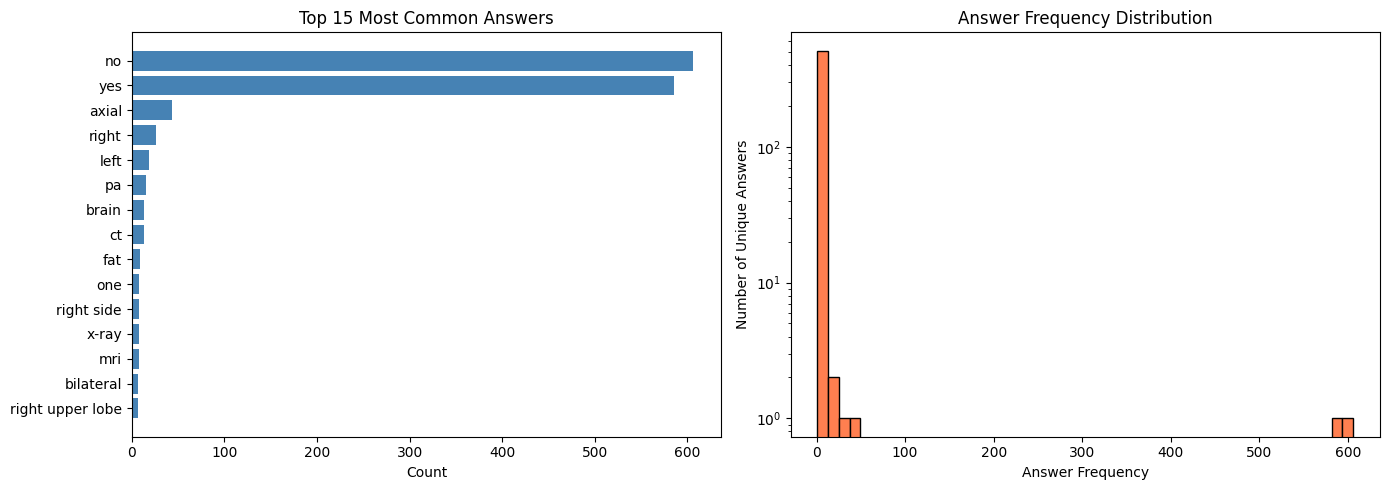


💾 Saved: answer_distribution.png


In [ ]:
# Visualize answer distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top 15 answers
top_15 = answer_counts.head(15)
axes[0].barh(range(len(top_15)), top_15.values, color='steelblue')
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15.index)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 15 Most Common Answers')
axes[0].invert_yaxis()

# Answer frequency distribution (log scale)
axes[1].hist(answer_counts.values, bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('Answer Frequency')
axes[1].set_ylabel('Number of Unique Answers')
axes[1].set_title('Answer Frequency Distribution')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('answer_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Saved: answer_distribution.png")

## 🔧 Part 4: Data Preparation with Proper Splits

**Important:** We use image-level splitting to prevent data leakage (questions from the same image shouldn't appear in both train and test).

In [ ]:
class VocabularyBuilder:
    """Build vocabulary for questions and answers."""

    def __init__(self, min_answer_freq: int = 1):
        self.min_answer_freq = min_answer_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}
        self.answer2idx = {'<UNK>': 0}
        self.idx2answer = {0: '<UNK>'}

    def build_vocab(self, questions: List[str], answers: List[str]):
        """Build vocabulary from training data."""
        # Build word vocabulary
        word_counter = Counter()
        for q in questions:
            words = str(q).lower().split()
            word_counter.update(words)

        for word, count in word_counter.items():
            if word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word

        # Build answer vocabulary (only answers with sufficient frequency)
        answer_counter = Counter(str(a).lower().strip() for a in answers)

        for answer, count in answer_counter.items():
            if count >= self.min_answer_freq and answer not in self.answer2idx:
                idx = len(self.answer2idx)
                self.answer2idx[answer] = idx
                self.idx2answer[idx] = answer

        print(f"📚 Vocabulary Statistics:")
        print(f"   Word vocabulary size: {len(self.word2idx)}")
        print(f"   Answer vocabulary size: {len(self.answer2idx)}")

        return self

    def get_vocab(self) -> Dict:
        return {
            'word2idx': self.word2idx,
            'idx2word': self.idx2word,
            'answer2idx': self.answer2idx,
            'idx2answer': self.idx2answer
        }

In [ ]:
class VQARADDataset(Dataset):
    """PyTorch Dataset for VQA-RAD."""

    def __init__(self,
                 hf_dataset,
                 indices: List[int],
                 vocab: Dict,
                 transform=None,
                 max_question_len: int = 20):
        """
        Args:
            hf_dataset: Hugging Face dataset split
            indices: List of indices to use from the dataset
            vocab: Vocabulary dictionary
            transform: Image transforms
            max_question_len: Maximum question length (tokens)
        """
        self.hf_dataset = hf_dataset
        self.indices = indices
        self.vocab = vocab
        self.transform = transform
        self.max_question_len = max_question_len

        self.word2idx = vocab['word2idx']
        self.answer2idx = vocab['answer2idx']
        self.idx2answer = vocab['idx2answer']

    def encode_question(self, question: str) -> torch.Tensor:
        """Tokenize and encode question."""
        words = str(question).lower().split()
        tokens = [self.word2idx.get(w, self.word2idx['<UNK>']) for w in words]

        # Pad or truncate
        if len(tokens) < self.max_question_len:
            tokens = tokens + [self.word2idx['<PAD>']] * (self.max_question_len - len(tokens))
        else:
            tokens = tokens[:self.max_question_len]

        return torch.tensor(tokens, dtype=torch.long)

    def encode_answer(self, answer: str) -> torch.Tensor:
        """Encode answer as class index."""
        answer = str(answer).lower().strip()
        idx = self.answer2idx.get(answer, self.answer2idx['<UNK>'])
        return torch.tensor(idx, dtype=torch.long)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
      # Get actual index from our subset
      real_idx = self.indices[idx]
      sample = self.hf_dataset[real_idx]

      # Load and transform image
      image = sample['image'].convert('RGB')
      if self.transform:
          image = self.transform(image)

      # Encode question and answer
      question_tokens = self.encode_question(sample['question'])
      answer_idx = self.encode_answer(sample['answer'])

      # Infer answer type from answer/question
      answer_lower = str(sample['answer']).lower().strip()
      question_lower = str(sample['question']).lower()

      CLOSED_ANSWERS = {'yes', 'no', 'ct', 'mri', 'x-ray', 'xray', 'axial',
                        'coronal', 'sagittal', '0', '1', '2', '3', '4', '5',
                        'one', 'two', 'three', 'none'}

      closed_patterns = ['is there', 'is this', 'are there', 'how many',
                         'what type of imaging', 'what plane']

      is_closed = 0
      if answer_lower in CLOSED_ANSWERS:
          is_closed = 1
      else:
          for pattern in closed_patterns:
              if pattern in question_lower:
                  is_closed = 1
                  break

      return {
          'image': image,
          'question': question_tokens,
          'answer': answer_idx,
          'answer_text': str(sample['answer']).lower().strip(),
         'question_text': str(sample['question']).lower(),
          'is_closed': is_closed
      }

In [ ]:
# Create proper train/validation/test splits
# We use the original HF splits but create a validation set from training

print("🔄 Creating data splits...\n")

# Get training data
train_hf = dataset['train']
test_hf = dataset['test']

# Create train/val split (85/15) from original training data
n_train = len(train_hf)
indices = list(range(n_train))
random.shuffle(indices)

split_idx = int(0.85 * n_train)
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]
test_indices = list(range(len(test_hf)))

print(f"📊 Data Split:")
print(f"   Training: {len(train_indices)} samples")
print(f"   Validation: {len(val_indices)} samples")
print(f"   Test: {len(test_indices)} samples")

# Build vocabulary from training data only
train_questions = [train_hf[i]['question'] for i in train_indices]
train_answers = [train_hf[i]['answer'] for i in train_indices]

vocab_builder = VocabularyBuilder(min_answer_freq=1)
vocab_builder.build_vocab(train_questions, train_answers)
vocab = vocab_builder.get_vocab()

🔄 Creating data splits...

📊 Data Split:
   Training: 1524 samples
   Validation: 269 samples
   Test: 451 samples
📚 Vocabulary Statistics:
   Word vocabulary size: 1305
   Answer vocabulary size: 390


In [ ]:
# Define image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = VQARADDataset(train_hf, train_indices, vocab, transform=train_transform)
val_dataset = VQARADDataset(train_hf, val_indices, vocab, transform=test_transform)
test_dataset = VQARADDataset(test_hf, test_indices, vocab, transform=test_transform)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=2, pin_memory=True)

print(f"\n✅ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Verify dataset works
print(f"\n🧪 Testing dataset...")
sample = train_dataset[0]
print(f"   Image shape: {sample['image'].shape}")
print(f"   Question shape: {sample['question'].shape}")
print(f"   Question: {sample['question_text']}")
print(f"   Answer: {sample['answer_text']}")
print(f"   Is closed: {sample['is_closed']}")


✅ DataLoaders created!
   Train batches: 48
   Val batches: 9
   Test batches: 15

🧪 Testing dataset...
   Image shape: torch.Size([3, 224, 224])
   Question shape: torch.Size([20])
   Question: is this a noncontrast ct?
   Answer: yes
   Is closed: 1


## 🏗️ Part 5: CNN-LSTM Model Architecture

### Architecture Overview:
1. **Visual Encoder:** ResNet-50 (pre-trained on ImageNet)
2. **Question Encoder:** Bidirectional LSTM with word embeddings
3. **Attention Mechanism:** Visual attention guided by question features
4. **Fusion Layer:** Concatenation + MLP
5. **Classifier:** Multi-class classification over answer vocabulary

In [ ]:
class VisualAttention(nn.Module):
    """Attention mechanism for visual features guided by question."""

    def __init__(self, visual_dim: int, question_dim: int, attention_dim: int = 512):
        super().__init__()
        self.visual_proj = nn.Linear(visual_dim, attention_dim)
        self.question_proj = nn.Linear(question_dim, attention_dim)
        self.attention = nn.Linear(attention_dim, 1)

    def forward(self, visual_features, question_features):
        """
        Args:
            visual_features: (batch, num_regions, visual_dim)
            question_features: (batch, question_dim)
        Returns:
            attended_visual: (batch, visual_dim)
            attention_weights: (batch, num_regions)
        """
        batch_size, num_regions, _ = visual_features.shape

        # Project visual features
        v_proj = self.visual_proj(visual_features)  # (batch, regions, attn_dim)

        # Project and expand question features
        q_proj = self.question_proj(question_features)  # (batch, attn_dim)
        q_proj = q_proj.unsqueeze(1).expand(-1, num_regions, -1)  # (batch, regions, attn_dim)

        # Compute attention scores
        combined = torch.tanh(v_proj + q_proj)
        attention_scores = self.attention(combined).squeeze(-1)  # (batch, regions)
        attention_weights = F.softmax(attention_scores, dim=1)

        # Apply attention
        attended_visual = torch.bmm(attention_weights.unsqueeze(1), visual_features).squeeze(1)

        return attended_visual, attention_weights

In [ ]:
class CNNLSTM_VQA(nn.Module):
    """CNN-LSTM architecture for Medical VQA with attention."""

    def __init__(self,
                 vocab_size: int,
                 answer_size: int,
                 embedding_dim: int = 300,
                 lstm_hidden: int = 512,
                 cnn_features: int = 2048,
                 dropout: float = 0.5,
                 use_attention: bool = True):
        super().__init__()

        self.use_attention = use_attention
        self.lstm_hidden = lstm_hidden

        # ============================================
        # Visual Encoder: ResNet-50 (pre-trained)
        # ============================================
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # Remove final pooling and FC for spatial features (for attention)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze early layers (first 6 blocks) for faster training
        for idx, child in enumerate(self.visual_encoder.children()):
            if idx < 6:
                for param in child.parameters():
                    param.requires_grad = False

        # Visual projection
        self.visual_projection = nn.Sequential(
            nn.Linear(cnn_features, lstm_hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # ============================================
        # Question Encoder: Bidirectional LSTM
        # ============================================
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            lstm_hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # ============================================
        # Attention Mechanism
        # ============================================
        if use_attention:
            self.attention = VisualAttention(
                visual_dim=cnn_features,
                question_dim=lstm_hidden * 2,  # bidirectional
                attention_dim=512
            )

        # ============================================
        # Fusion and Classification
        # ============================================
        # Question features: lstm_hidden * 2 (bidirectional)
        # Visual features: lstm_hidden (after projection) or cnn_features (with attention)
        if use_attention:
            fusion_input = lstm_hidden * 2 + cnn_features
        else:
            fusion_input = lstm_hidden * 2 + lstm_hidden

        self.fusion = nn.Sequential(
            nn.Linear(fusion_input, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.classifier = nn.Linear(512, answer_size)

    def forward(self, images, questions):
        batch_size = images.size(0)

        # ============================================
        # Extract Visual Features
        # ============================================
        visual_features = self.visual_encoder(images)  # (batch, 2048, 7, 7)

        if self.use_attention:
            # Reshape for attention: (batch, 49, 2048)
            visual_features_flat = visual_features.view(batch_size, 2048, -1).permute(0, 2, 1)
        else:
            # Global average pooling
            visual_features = F.adaptive_avg_pool2d(visual_features, 1)
            visual_features = visual_features.view(batch_size, -1)  # (batch, 2048)
            visual_features = self.visual_projection(visual_features)  # (batch, 512)

        # ============================================
        # Extract Question Features
        # ============================================
        question_embeds = self.embedding(questions)  # (batch, seq_len, 300)
        lstm_out, (hidden, cell) = self.lstm(question_embeds)

        # Concatenate final forward and backward hidden states
        # hidden shape: (num_layers * 2, batch, hidden)
        question_features = torch.cat([hidden[-2], hidden[-1]], dim=1)  # (batch, 1024)

        # ============================================
        # Apply Attention (if enabled)
        # ============================================
        if self.use_attention:
            attended_visual, attn_weights = self.attention(visual_features_flat, question_features)
            combined = torch.cat([attended_visual, question_features], dim=1)
        else:
            combined = torch.cat([visual_features, question_features], dim=1)

        # ============================================
        # Fusion and Classification
        # ============================================
        fused = self.fusion(combined)
        logits = self.classifier(fused)

        return logits

In [ ]:
# Initialize model
model = CNNLSTM_VQA(
    vocab_size=len(vocab['word2idx']),
    answer_size=len(vocab['answer2idx']),
    embedding_dim=300,
    lstm_hidden=512,
    dropout=0.5,
    use_attention=True  # Enable attention mechanism
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Frozen parameters: {total_params - trainable_params:,}")
print(f"   Answer classes: {len(vocab['answer2idx'])}")


📊 Model Statistics:
   Total parameters: 40,028,435
   Trainable parameters: 38,583,507
   Frozen parameters: 1,444,928
   Answer classes: 390


## 🎯 Part 6: Training Loop with Class Imbalance Handling

In [ ]:
def compute_class_weights(dataset, vocab, device):
    """Compute class weights for handling imbalanced answers."""
    answer_counts = Counter()

    for i in range(len(dataset)):
        sample = dataset[i]
        answer_counts[sample['answer'].item()] += 1

    # Compute inverse frequency weights
    num_classes = len(vocab['answer2idx'])
    weights = torch.ones(num_classes)

    total_samples = sum(answer_counts.values())
    for idx, count in answer_counts.items():
        if count > 0:
            # Inverse frequency with smoothing
            weights[idx] = total_samples / (num_classes * count)

    # Clip extreme weights
    weights = torch.clamp(weights, min=0.1, max=10.0)

    return weights.to(device)

# Compute class weights (optional - can be slow for large datasets)
print("⚖️ Computing class weights for imbalanced data...")
# class_weights = compute_class_weights(train_dataset, vocab, device)
# For faster training, use uniform weights
class_weights = None
print("   Using uniform weights for faster training")

⚖️ Computing class weights for imbalanced data...
   Using uniform weights for faster training


In [ ]:
class Trainer:
    """Training class for CNN-LSTM VQA model."""

    def __init__(self, model, train_loader, val_loader, vocab, device,
                 learning_rate=1e-4, weight_decay=1e-5, class_weights=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.vocab = vocab
        self.device = device

        # Loss function (with optional class weights)
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)

        # Optimizer with weight decay
        self.optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=3
        )

        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'val_acc_closed': [], 'val_acc_open': [],
            'learning_rate': []
        }

        self.best_val_acc = 0
        self.best_model_state = None

    def train_epoch(self):
        """Train for one epoch."""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for batch in pbar:
            images = batch['image'].to(self.device)
            questions = batch['question'].to(self.device)
            answers = batch['answer'].to(self.device)

            self.optimizer.zero_grad()

            logits = self.model(images, questions)
            loss = self.criterion(logits, answers)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == answers).sum().item()
            total += answers.size(0)

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{correct/total:.4f}'})

        return total_loss / len(self.train_loader), correct / total

    @torch.no_grad()
    def evaluate(self, loader):
        """Evaluate on validation/test set."""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        # Track closed vs open accuracy
        correct_closed = 0
        total_closed = 0
        correct_open = 0
        total_open = 0

        all_preds = []
        all_labels = []
        all_is_closed = []

        for batch in tqdm(loader, desc='Evaluating'):
            images = batch['image'].to(self.device)
            questions = batch['question'].to(self.device)
            answers = batch['answer'].to(self.device)
            is_closed = batch['is_closed']

            logits = self.model(images, questions)
            loss = self.criterion(logits, answers)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)

            # Overall accuracy
            correct += (preds == answers).sum().item()
            total += answers.size(0)

            # Per-type accuracy
            for i in range(len(answers)):
                if is_closed[i] == 1:
                    total_closed += 1
                    if preds[i] == answers[i]:
                        correct_closed += 1
                else:
                    total_open += 1
                    if preds[i] == answers[i]:
                        correct_open += 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(answers.cpu().numpy())
            all_is_closed.extend(is_closed.numpy())

        metrics = {
            'loss': total_loss / len(loader),
            'accuracy': correct / total,
            'accuracy_closed': correct_closed / total_closed if total_closed > 0 else 0,
            'accuracy_open': correct_open / total_open if total_open > 0 else 0,
            'predictions': all_preds,
            'labels': all_labels,
            'is_closed': all_is_closed,
            'n_closed': total_closed,
            'n_open': total_open
        }

        return metrics

    def train(self, num_epochs: int = 20, early_stop_patience: int = 7):
        """Full training loop with early stopping."""
        patience_counter = 0

        print(f"\n🚀 Starting training for {num_epochs} epochs...\n")

        for epoch in range(num_epochs):
            print(f"\n{'='*60}")
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"{'='*60}")

            # Train
            train_loss, train_acc = self.train_epoch()

            # Validate
            val_metrics = self.evaluate(self.val_loader)

            # Update scheduler
            self.scheduler.step(val_metrics['accuracy'])

            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_metrics['accuracy'])
            self.history['val_acc_closed'].append(val_metrics['accuracy_closed'])
            self.history['val_acc_open'].append(val_metrics['accuracy_open'])
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])

            # Print metrics
            print(f"\n📊 Results:")
            print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"   Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
            print(f"   Val Acc (Closed): {val_metrics['accuracy_closed']:.4f} ({val_metrics['n_closed']} samples)")
            print(f"   Val Acc (Open): {val_metrics['accuracy_open']:.4f} ({val_metrics['n_open']} samples)")

            # Save best model
            if val_metrics['accuracy'] > self.best_val_acc:
                self.best_val_acc = val_metrics['accuracy']
                self.best_model_state = self.model.state_dict().copy()
                patience_counter = 0
                print(f"   ✨ New best model! Val Acc: {self.best_val_acc:.4f}")
            else:
                patience_counter += 1
                print(f"   ⏳ No improvement for {patience_counter} epochs")

            # Early stopping
            if patience_counter >= early_stop_patience:
                print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs")
                break

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f"\n✅ Loaded best model with Val Acc: {self.best_val_acc:.4f}")

        return self.history

In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    device=device,
    learning_rate=1e-4,
    weight_decay=1e-5,
    class_weights=class_weights
)

# Train the model
history = trainer.train(num_epochs=25, early_stop_patience=7)


🚀 Starting training for 25 epochs...


Epoch 1/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 4.7763 | Train Acc: 0.2546
   Val Loss: 4.4250 | Val Acc: 0.2862
   Val Acc (Closed): 0.5274 (146 samples)
   Val Acc (Open): 0.0000 (123 samples)
   ✨ New best model! Val Acc: 0.2862

Epoch 2/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 3.8429 | Train Acc: 0.2940
   Val Loss: 4.0949 | Val Acc: 0.2937
   Val Acc (Closed): 0.5411 (146 samples)
   Val Acc (Open): 0.0000 (123 samples)
   ✨ New best model! Val Acc: 0.2937

Epoch 3/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 3.3806 | Train Acc: 0.3097
   Val Loss: 3.8274 | Val Acc: 0.2937
   Val Acc (Closed): 0.5411 (146 samples)
   Val Acc (Open): 0.0000 (123 samples)
   ⏳ No improvement for 1 epochs

Epoch 4/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 3.1531 | Train Acc: 0.3130
   Val Loss: 3.7734 | Val Acc: 0.2974
   Val Acc (Closed): 0.5479 (146 samples)
   Val Acc (Open): 0.0000 (123 samples)
   ✨ New best model! Val Acc: 0.2974

Epoch 5/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 3.0487 | Train Acc: 0.3425
   Val Loss: 3.8455 | Val Acc: 0.2937
   Val Acc (Closed): 0.5411 (146 samples)
   Val Acc (Open): 0.0000 (123 samples)
   ⏳ No improvement for 1 epochs

Epoch 6/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():
^ ^ ^ ^ ^ ^  ^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ 
   File "/usr/lib/py


📊 Results:
   Train Loss: 3.0051 | Train Acc: 0.3524
   Val Loss: 3.8374 | Val Acc: 0.3160
   Val Acc (Closed): 0.5822 (146 samples)
   Val Acc (Open): 0.0000 (123 samples)
   ✨ New best model! Val Acc: 0.3160

Epoch 7/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.9092 | Train Acc: 0.3780
   Val Loss: 3.7954 | Val Acc: 0.3011
   Val Acc (Closed): 0.5548 (146 samples)
   Val Acc (Open): 0.0000 (123 samples)
   ⏳ No improvement for 1 epochs

Epoch 8/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.8507 | Train Acc: 0.3957
   Val Loss: 3.7638 | Val Acc: 0.3309
   Val Acc (Closed): 0.6096 (146 samples)
   Val Acc (Open): 0.0000 (123 samples)
   ✨ New best model! Val Acc: 0.3309

Epoch 9/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.7355 | Train Acc: 0.4180
   Val Loss: 3.9739 | Val Acc: 0.3532
   Val Acc (Closed): 0.6370 (146 samples)
   Val Acc (Open): 0.0163 (123 samples)
   ✨ New best model! Val Acc: 0.3532

Epoch 10/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.6622 | Train Acc: 0.4068
   Val Loss: 3.7604 | Val Acc: 0.3457
   Val Acc (Closed): 0.6233 (146 samples)
   Val Acc (Open): 0.0163 (123 samples)
   ⏳ No improvement for 1 epochs

Epoch 11/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.5624 | Train Acc: 0.4304
   Val Loss: 3.7829 | Val Acc: 0.3606
   Val Acc (Closed): 0.6507 (146 samples)
   Val Acc (Open): 0.0163 (123 samples)
   ✨ New best model! Val Acc: 0.3606

Epoch 12/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
         ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^^    ^if w.is_alive():^
^ ^^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^^^ ^ ^^  ^ ^ ^  ^  
   File "/usr

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 2.4257 | Train Acc: 0.4528
   Val Loss: 3.8082 | Val Acc: 0.3643
   Val Acc (Closed): 0.6575 (146 samples)
   Val Acc (Open): 0.0163 (123 samples)
   ✨ New best model! Val Acc: 0.3643

Epoch 13/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.3213 | Train Acc: 0.4751
   Val Loss: 3.7834 | Val Acc: 0.3420
   Val Acc (Closed): 0.6096 (146 samples)
   Val Acc (Open): 0.0244 (123 samples)
   ⏳ No improvement for 1 epochs

Epoch 14/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.2488 | Train Acc: 0.4823
   Val Loss: 4.3400 | Val Acc: 0.3680
   Val Acc (Closed): 0.6507 (146 samples)
   Val Acc (Open): 0.0325 (123 samples)
   ✨ New best model! Val Acc: 0.3680

Epoch 15/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.1199 | Train Acc: 0.5046
   Val Loss: 3.7881 | Val Acc: 0.3792
   Val Acc (Closed): 0.6712 (146 samples)
   Val Acc (Open): 0.0325 (123 samples)
   ✨ New best model! Val Acc: 0.3792

Epoch 16/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 2.0120 | Train Acc: 0.5394
   Val Loss: 3.9503 | Val Acc: 0.3978
   Val Acc (Closed): 0.6849 (146 samples)
   Val Acc (Open): 0.0569 (123 samples)
   ✨ New best model! Val Acc: 0.3978

Epoch 17/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.9207 | Train Acc: 0.5545
   Val Loss: 4.0833 | Val Acc: 0.3941
   Val Acc (Closed): 0.6849 (146 samples)
   Val Acc (Open): 0.0488 (123 samples)
   ⏳ No improvement for 1 epochs

Epoch 18/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.8304 | Train Acc: 0.5669
   Val Loss: 3.9984 | Val Acc: 0.3978
   Val Acc (Closed): 0.6712 (146 samples)
   Val Acc (Open): 0.0732 (123 samples)
   ⏳ No improvement for 2 epochs

Epoch 19/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.6862 | Train Acc: 0.5879
   Val Loss: 4.1368 | Val Acc: 0.3829
   Val Acc (Closed): 0.6644 (146 samples)
   Val Acc (Open): 0.0488 (123 samples)
   ⏳ No improvement for 3 epochs

Epoch 20/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.6078 | Train Acc: 0.6109
   Val Loss: 4.3712 | Val Acc: 0.3866
   Val Acc (Closed): 0.6507 (146 samples)
   Val Acc (Open): 0.0732 (123 samples)
   ⏳ No improvement for 4 epochs

Epoch 21/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.5052 | Train Acc: 0.6411
   Val Loss: 4.3160 | Val Acc: 0.4201
   Val Acc (Closed): 0.6918 (146 samples)
   Val Acc (Open): 0.0976 (123 samples)
   ✨ New best model! Val Acc: 0.4201

Epoch 22/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.3853 | Train Acc: 0.6476
   Val Loss: 4.4592 | Val Acc: 0.4275
   Val Acc (Closed): 0.7123 (146 samples)
   Val Acc (Open): 0.0894 (123 samples)
   ✨ New best model! Val Acc: 0.4275

Epoch 23/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78656238ed40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 1.3668 | Train Acc: 0.6654
   Val Loss: 4.4470 | Val Acc: 0.4238
   Val Acc (Closed): 0.6918 (146 samples)
   Val Acc (Open): 0.1057 (123 samples)
   ⏳ No improvement for 1 epochs

Epoch 24/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.2681 | Train Acc: 0.6857
   Val Loss: 4.6511 | Val Acc: 0.4535
   Val Acc (Closed): 0.7397 (146 samples)
   Val Acc (Open): 0.1138 (123 samples)
   ✨ New best model! Val Acc: 0.4535

Epoch 25/25


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.2486 | Train Acc: 0.6804
   Val Loss: 4.5887 | Val Acc: 0.4461
   Val Acc (Closed): 0.7123 (146 samples)
   Val Acc (Open): 0.1301 (123 samples)
   ⏳ No improvement for 1 epochs

✅ Loaded best model with Val Acc: 0.4535


## 📈 Part 7: Training Visualization

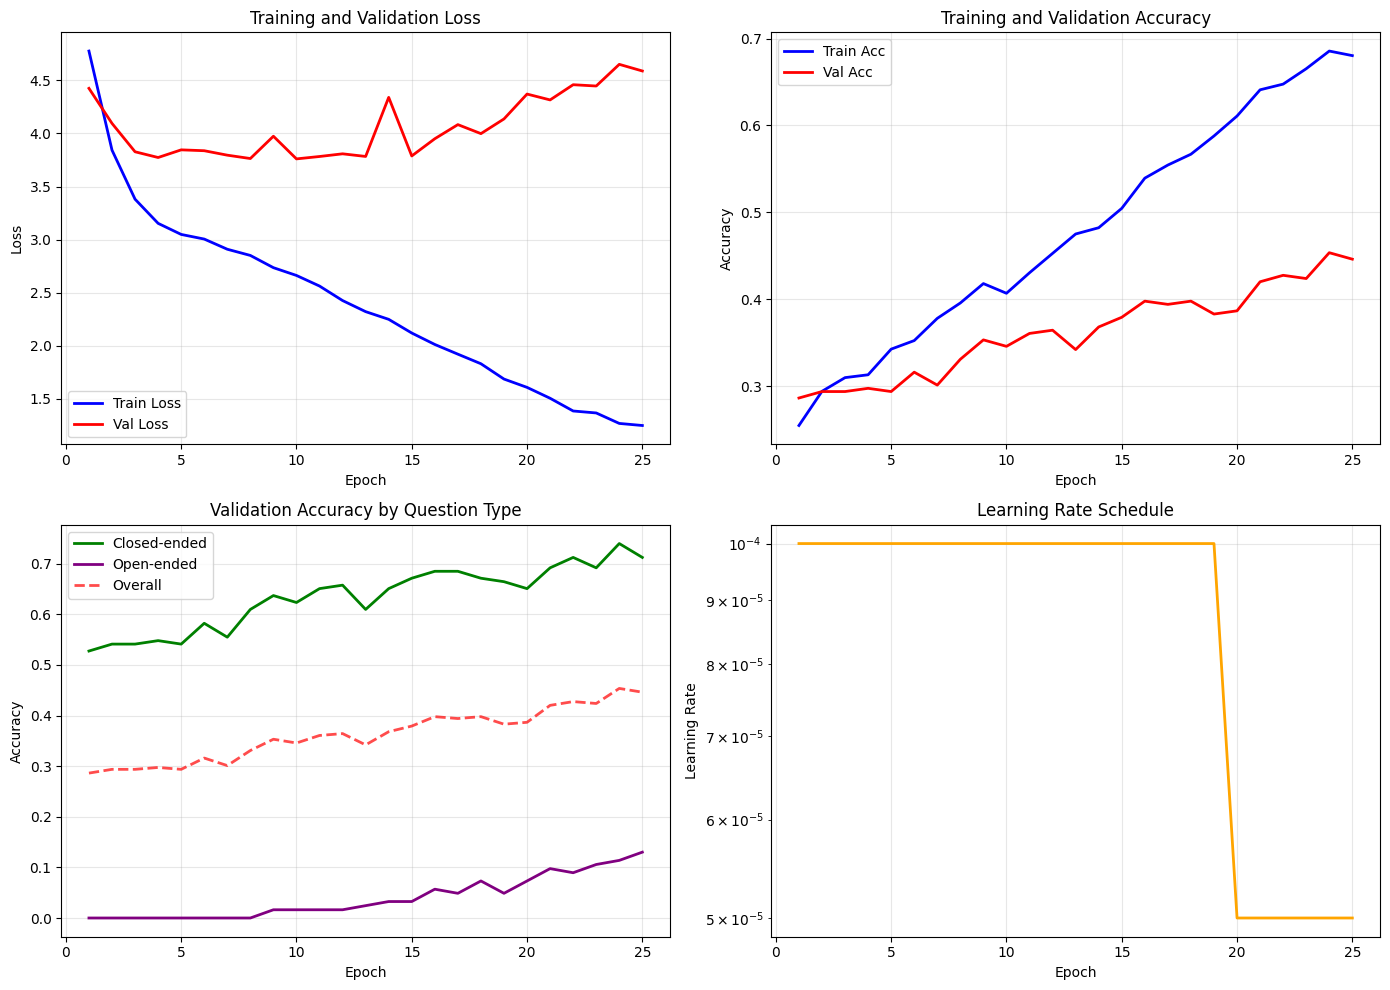


💾 Saved: cnn_lstm_training_history.png


In [ ]:
def plot_training_history(history):
    """Plot comprehensive training history."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Overall Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Closed vs Open Accuracy
    axes[1, 0].plot(epochs, history['val_acc_closed'], 'g-', label='Closed-ended', linewidth=2)
    axes[1, 0].plot(epochs, history['val_acc_open'], 'purple', label='Open-ended', linewidth=2)
    axes[1, 0].plot(epochs, history['val_acc'], 'r--', label='Overall', linewidth=2, alpha=0.7)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Validation Accuracy by Question Type')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 1].plot(epochs, history['learning_rate'], 'orange', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cnn_lstm_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n💾 Saved: cnn_lstm_training_history.png")

plot_training_history(history)

## 🧪 Part 8: Test Set Evaluation

In [ ]:
print("\n" + "="*60)
print("🧪 FINAL TEST SET EVALUATION")
print("="*60)

# Evaluate on test set
test_metrics = trainer.evaluate(test_loader)

print(f"\n📊 Test Set Results:")
print(f"   Overall Accuracy: {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"   Closed-ended Accuracy: {test_metrics['accuracy_closed']:.4f} ({test_metrics['accuracy_closed']*100:.2f}%)")
print(f"   Open-ended Accuracy: {test_metrics['accuracy_open']:.4f} ({test_metrics['accuracy_open']*100:.2f}%)")
print(f"\n   Closed-ended samples: {test_metrics['n_closed']}")
print(f"   Open-ended samples: {test_metrics['n_open']}")


🧪 FINAL TEST SET EVALUATION


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]


📊 Test Set Results:
   Overall Accuracy: 0.3415 (34.15%)
   Closed-ended Accuracy: 0.5294 (52.94%)
   Open-ended Accuracy: 0.0062 (0.62%)

   Closed-ended samples: 289
   Open-ended samples: 162


In [ ]:
def analyze_predictions(test_metrics, vocab, n_examples=10):
    """Analyze model predictions."""
    idx2answer = vocab['idx2answer']

    preds = test_metrics['predictions']
    labels = test_metrics['labels']
    is_closed = test_metrics['is_closed']

    # Confusion analysis
    correct_closed = []
    incorrect_closed = []
    correct_open = []
    incorrect_open = []

    for i, (pred, label, closed) in enumerate(zip(preds, labels, is_closed)):
        pred_text = idx2answer.get(pred, '<UNK>')
        label_text = idx2answer.get(label, '<UNK>')

        if pred == label:
            if closed:
                correct_closed.append((pred_text, label_text))
            else:
                correct_open.append((pred_text, label_text))
        else:
            if closed:
                incorrect_closed.append((pred_text, label_text))
            else:
                incorrect_open.append((pred_text, label_text))

    print("\n📋 Prediction Analysis:")
    print(f"\n   Correct Closed-ended: {len(correct_closed)}")
    print(f"   Incorrect Closed-ended: {len(incorrect_closed)}")
    print(f"   Correct Open-ended: {len(correct_open)}")
    print(f"   Incorrect Open-ended: {len(incorrect_open)}")

    # Show some incorrect predictions
    print(f"\n❌ Sample Incorrect Predictions (Closed-ended):")
    for pred, label in incorrect_closed[:5]:
        print(f"   Predicted: '{pred}' | Actual: '{label}'")

    print(f"\n❌ Sample Incorrect Predictions (Open-ended):")
    for pred, label in incorrect_open[:5]:
        print(f"   Predicted: '{pred}' | Actual: '{label}'")

    return {
        'correct_closed': len(correct_closed),
        'incorrect_closed': len(incorrect_closed),
        'correct_open': len(correct_open),
        'incorrect_open': len(incorrect_open)
    }

pred_analysis = analyze_predictions(test_metrics, vocab)


📋 Prediction Analysis:

   Correct Closed-ended: 153
   Incorrect Closed-ended: 136
   Correct Open-ended: 1
   Incorrect Open-ended: 161

❌ Sample Incorrect Predictions (Closed-ended):
   Predicted: 'no' | Actual: 'yes'
   Predicted: 'no' | Actual: 'yes'
   Predicted: 'yes' | Actual: 'no'
   Predicted: 'yes' | Actual: 'no'
   Predicted: 'no' | Actual: 'yes'

❌ Sample Incorrect Predictions (Open-ended):
   Predicted: 'left' | Actual: 'right'
   Predicted: 'left side' | Actual: '<UNK>'
   Predicted: 'no' | Actual: 'left'
   Predicted: 'left kidney' | Actual: 'left'
   Predicted: 'solid' | Actual: '<UNK>'


## 💾 Part 9: Save Model and Results

In [ ]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'history': history,
    'test_metrics': {
        'accuracy': test_metrics['accuracy'],
        'accuracy_closed': test_metrics['accuracy_closed'],
        'accuracy_open': test_metrics['accuracy_open'],
        'n_closed': test_metrics['n_closed'],
        'n_open': test_metrics['n_open']
    },
    'model_config': {
        'vocab_size': len(vocab['word2idx']),
        'answer_size': len(vocab['answer2idx']),
        'embedding_dim': 300,
        'lstm_hidden': 512,
        'use_attention': True
    }
}

torch.save(checkpoint, 'cnn_lstm_vqa_checkpoint.pt')
print("\n💾 Saved: cnn_lstm_vqa_checkpoint.pt")

# Save results summary
results_summary = {
    'model': 'CNN-LSTM with Attention',
    'dataset': 'VQA-RAD',
    'test_accuracy_overall': test_metrics['accuracy'],
    'test_accuracy_closed': test_metrics['accuracy_closed'],
    'test_accuracy_open': test_metrics['accuracy_open'],
    'n_test_closed': test_metrics['n_closed'],
    'n_test_open': test_metrics['n_open'],
    'best_val_accuracy': trainer.best_val_acc,
    'num_epochs_trained': len(history['train_loss']),
    'vocab_size': len(vocab['word2idx']),
    'answer_classes': len(vocab['answer2idx']),
    'trainable_params': trainable_params
}

with open('cnn_lstm_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("💾 Saved: cnn_lstm_results.json")


💾 Saved: cnn_lstm_vqa_checkpoint.pt
💾 Saved: cnn_lstm_results.json


In [ ]:
# Print final summary
print("\n" + "="*60)
print("📊 CNN-LSTM BASELINE - FINAL SUMMARY")
print("="*60)
print(f"""
Model: CNN-LSTM with Visual Attention
Dataset: VQA-RAD (Hugging Face)

Architecture:
  - Visual Encoder: ResNet-50 (ImageNet pre-trained)
  - Question Encoder: Bidirectional LSTM (2 layers)
  - Attention: Visual attention guided by question
  - Trainable Parameters: {trainable_params:,}

Training:
  - Epochs: {len(history['train_loss'])}
  - Best Validation Accuracy: {trainer.best_val_acc:.4f} ({trainer.best_val_acc*100:.2f}%)

Test Results:
  - Overall Accuracy: {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)
  - Closed-ended Accuracy: {test_metrics['accuracy_closed']:.4f} ({test_metrics['accuracy_closed']*100:.2f}%)
  - Open-ended Accuracy: {test_metrics['accuracy_open']:.4f} ({test_metrics['accuracy_open']*100:.2f}%)

Files Saved:
  - cnn_lstm_vqa_checkpoint.pt (model weights)
  - cnn_lstm_results.json (results summary)
  - cnn_lstm_training_history.png (training plots)
  - answer_distribution.png (data analysis)
""")
print("="*60)


📊 CNN-LSTM BASELINE - FINAL SUMMARY

Model: CNN-LSTM with Visual Attention
Dataset: VQA-RAD (Hugging Face)

Architecture:
  - Visual Encoder: ResNet-50 (ImageNet pre-trained)
  - Question Encoder: Bidirectional LSTM (2 layers)
  - Attention: Visual attention guided by question
  - Trainable Parameters: 38,583,507

Training:
  - Epochs: 25
  - Best Validation Accuracy: 0.4535 (45.35%)

Test Results:
  - Overall Accuracy: 0.3415 (34.15%)
  - Closed-ended Accuracy: 0.5294 (52.94%)
  - Open-ended Accuracy: 0.0062 (0.62%)

Files Saved:
  - cnn_lstm_vqa_checkpoint.pt (model weights)
  - cnn_lstm_results.json (results summary)
  - cnn_lstm_training_history.png (training plots)
  - answer_distribution.png (data analysis)



## 🔄 Part 10: Load Model (for later use)

Use this cell to load a previously saved model.

In [ ]:
def load_cnn_lstm_model(checkpoint_path: str, device):
    """Load a saved CNN-LSTM model."""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    config = checkpoint['model_config']

    model = CNNLSTM_VQA(
        vocab_size=config['vocab_size'],
        answer_size=config['answer_size'],
        embedding_dim=config['embedding_dim'],
        lstm_hidden=config['lstm_hidden'],
        use_attention=config['use_attention']
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model, checkpoint['vocab'], checkpoint['test_metrics']

# Example usage:
# loaded_model, loaded_vocab, saved_metrics = load_cnn_lstm_model('cnn_lstm_vqa_checkpoint.pt', device)
# print(f"Loaded model with test accuracy: {saved_metrics['accuracy']:.4f}")

---

## 📝 Notes for Assignment Report

### Key Findings:
1. **Class Imbalance Challenge:** The VQA-RAD dataset has severe class imbalance with Yes/No answers dominating (~50% of data)
2. **Closed vs Open Gap:** Significant performance difference between closed-ended and open-ended questions
3. **Generalization Gap:** Training accuracy typically exceeds validation/test accuracy due to limited data

### Limitations:
1. **Classification Approach:** Treats answers as discrete classes, cannot generate novel answers
2. **Limited Vocabulary:** Cannot handle answers not seen during training
3. **No Semantic Understanding:** Cannot recognize semantically equivalent answers (e.g., "chest" vs "thorax")

### Next Steps:
- Proceed to **BLIP-2 notebook** for VLM comparison
- The BLIP-2 model addresses these limitations through:
  - Generative approach (not limited to fixed vocabulary)
  - Large-scale pre-training (better generalization)
  - Semantic understanding from language models

---